## podstawowe operacje

In [4]:
from skimage import data
from skimage import exposure
import matplotlib.pyplot as plt

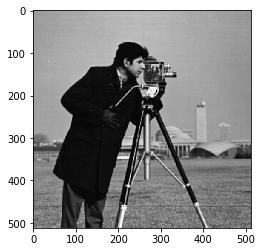

In [5]:
img = data.camera()

plt.imshow(img, cmap='gray')
plt.show()

In [6]:
#img jest macierzą dwuwymiarową przechowywującą skale szarości jako ośmiobitowy unsigned int 
print img.shape, img.dtype

(512, 512) uint8


[[ 10  10  10 ...,  82  98 124]
 [ 10  10  10 ...,  85 108 140]
 [  9   9   9 ...,  66  81  97]
 ..., 
 [ 13  12  13 ...,  32  30  36]
 [ 10   9  10 ...,  31  28  30]
 [  8   8   8 ...,  32  29  31]]


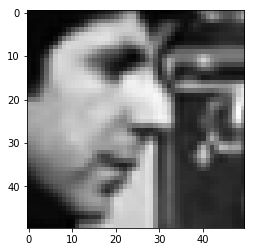

In [7]:
print img[110:160, 230:280]
plt.imshow(img[110:160, 230:280], cmap='gray')
plt.show()

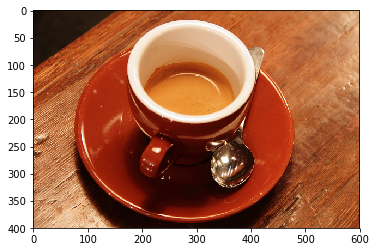

In [8]:
img = data.coffee()
plt.imshow(img)
plt.show()

Informacje o kolorywch obrazach przechowujemy w trójwymiarowej macierzy, gdzie ostatni wymiar składa się z trzech wartości. Mówimy o tym kanały lub składowe kolorów. Najczęściej reprezentujemy je w postaci kanałów RGB (czyli składowej koloru czerwonego, zielonego i niebieskiego)

In [9]:
print img.shape, img.dtype

(400, 600, 3) uint8


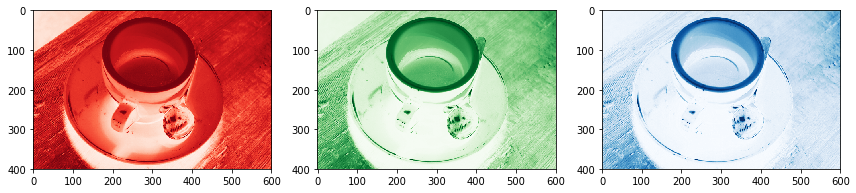

In [10]:
fig = plt.figure(figsize=(12, 4))

axes = []
for i in range(1, 4):
    axes.append( fig.add_subplot(1, 3, i) ) 
    
axes[0].imshow(img[:,:,0], cmap='Reds')
axes[1].imshow(img[:,:,1], cmap='Greens')
axes[2].imshow(img[:,:,2], cmap='Blues')

plt.tight_layout()
plt.show()


O wiele naturalniejszą przetrzenią kolorów jest dla człowieka jest przestrzeń HSV

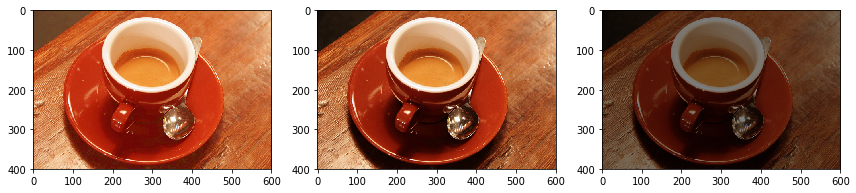

In [11]:
from skimage import color

img = data.coffee()

#zwróc uwagę, że teraz img jest typu zmienno przecikowego przyjmujac wartości 0-1
img = color.rgb2hsv(img)

fig = plt.figure(figsize=(12, 4))

axes = []
for i in range(1, 4):
    axes.append( fig.add_subplot(1, 3, i) ) 
    
brighten_img = img.copy()
brighten_img[:,:,2] += 0.5
brighten_img[:,:,2] /= brighten_img[:,:,2].max() #znormalizujmy do 0-1

darker_img = img.copy()
darker_img[:,:,2] *= 0.5

axes[0].imshow(color.hsv2rgb(brighten_img))
axes[1].imshow(color.hsv2rgb(img))
axes[2].imshow(color.hsv2rgb(darker_img))
plt.tight_layout()
plt.show()

## histogram i binaryzacja

Rozpatrzymy teraz problem binaryzacji, segmentacji oraz klasyfikacji obiektów na obrazie.

Zacznijmy od wczytania obrazu

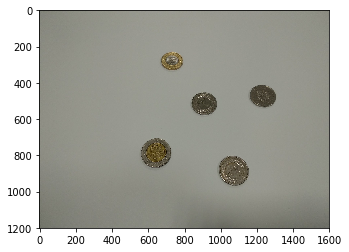

In [155]:
from skimage import io #zaimportujmy moduł odpowiedzialny za odczyt danych z dysku 
import os 


coin_imgs = []
for fn in os.listdir('./data/coins'):
    coin_imgs.append(io.imread('./data/coins/' + fn))
    
plt.imshow(coin_imgs[0])
plt.show()


Postaramy się teraz dokonać segemtntacji w oparciu o histogram skali szarości. Najpier na przykładzie z pojedynczym obrazem.

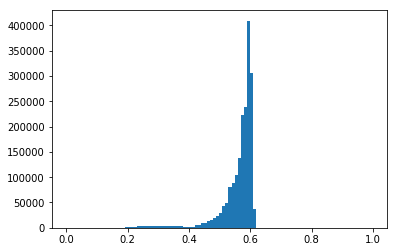

In [159]:
img = coin_imgs[0]

img = color.rgb2gray(img) #zamiana na skale szarości

plt.hist(img.flatten(), bins = 100)
plt.show()

Widzimy, że dane w rozpiętości tonalnej naszego zdjęcia mieszczą sie w bardzo małym obszarze. Postarajmy się to zmienić ujednolicając histogram [link](http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html) 

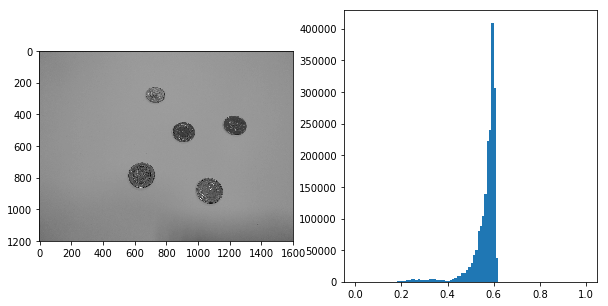

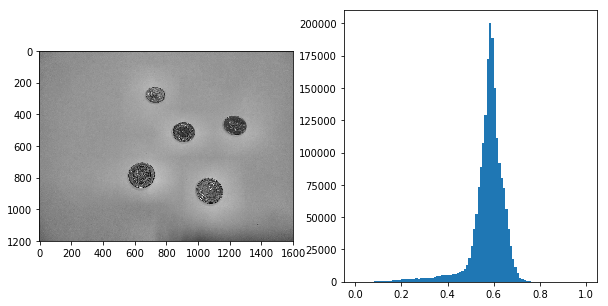

In [160]:
from skimage import exposure

#zastusujemy jeszce wygładzanie obrazka
# img = filters.gaussian(img, sigma = 9)

img_adapt_equalization = exposure.equalize_adapthist(img)
img_rescaled = exposure.rescale_intensity(img)


fig = plt.figure(figsize=(10,5))
ax_img = fig.add_subplot(121)
ax_hist = fig.add_subplot(122)

ax_img.imshow(img_rescaled, cmap='gray')
ax_hist.hist(img_rescaled.flatten(), bins = 100)


fig = plt.figure(figsize=(10,5))
ax_img = fig.add_subplot(121)
ax_hist = fig.add_subplot(122)

ax_img.imshow(img_adapt_equalization, cmap='gray')
ax_hist.hist(img_adapt_equalization.flatten(), bins = 100)
plt.show()

plt.show()

Widzimy, że przeskalowanie rozpietosci tonalnej miedzy najwyższa i najmniejsza wartość daje pożądane rezultaty. Dodaktowo to co możemy odcyztać z hisogramu to, to że istnieje że największość wartość kolory przypada na jasno szary. Zwróć uwagę, że widać niewielkie lokalne minimum w okolicach 0.45 na histogramie. 

Stwórzmy zatem binaryzacje (czyli zamiane na wartości {0,1} poprzez zastosowanie progu odcięcia)

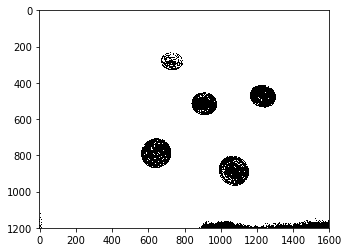

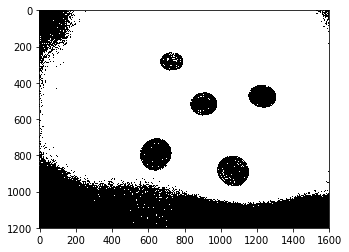

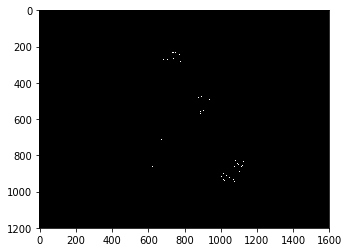

In [162]:
img_bin = img_rescaled < 0.45

#img_bin jest teraz macierza binarną

#oraz przyjrzyjmy się innym progowaniom
plt.figure(); plt.imshow( img_rescaled < 0.45 , cmap='binary') 
plt.figure(); plt.imshow( img_rescaled < 0.55 , cmap='binary') 
plt.figure(); plt.imshow( img_rescaled < 0.7 , cmap='binary') 
plt.show()

Wygląda na to, że próg 0.4 jest najbardziej obiecujący (mimo, iż powstał duży obszar u dołu zdjęcia). Niemniej jednak nie straciliśmy w nim żadnych danych. 

Wybraiśmy próg ręcznie ale przyjrzyjmy sie różnym metodom na wybranie tego progu automatycznie (na podstawie hisogramów) [link](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html)

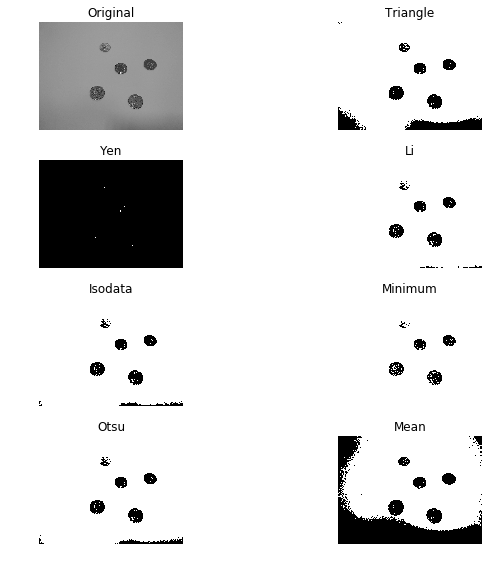

In [163]:
fig, ax = filters.try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

W jednej z monet widzimy "dziurę" postarajmy się ją "zamnąć" stosujac serię [erosji](https://en.wikipedia.org/wiki/Erosion_(morphology)) oraz [dylacji](https://en.wikipedia.org/wiki/Dilation_(morphology)).

Do wykrozystania tego mamy prostą funkcję z modułu skimage.morphology


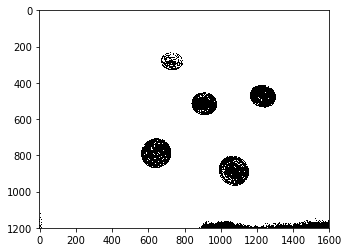

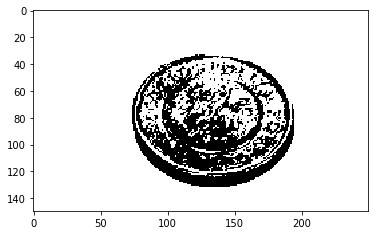

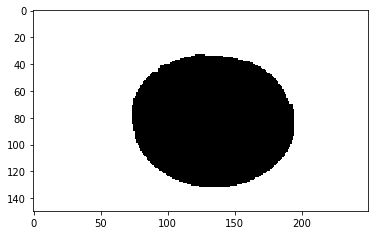

In [167]:
from skimage import morphology

img_bin = img_rescaled < 0.45


plt.figure(); plt.imshow(img_bin, cmap='binary')
plt.figure(); plt.imshow(img_bin[200:350, 600:850], cmap='binary')

img_bin = morphology.binary_closing(img_bin, selem=np.ones((20,20)))

plt.figure(); plt.imshow(img_bin[200:350, 600:850], cmap='binary')

plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11]


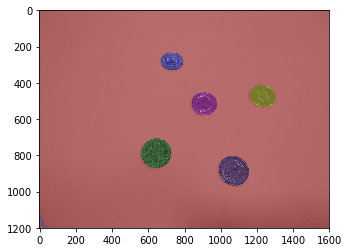

In [170]:
from skimage import measure

label_img = measure.label(img_bin)
image_label_overlay = color.label2rgb(label_img, image=img)

print np.unique(label_img)
plt.imshow(image_label_overlay)
plt.show()

1 9539
2 14197
3 14103
4 21597
5 21681
6 4
7 8
8 2
9 1
10 18197
11 898


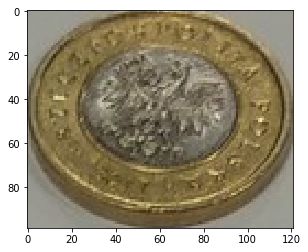

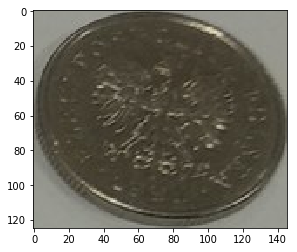

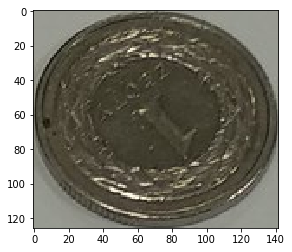

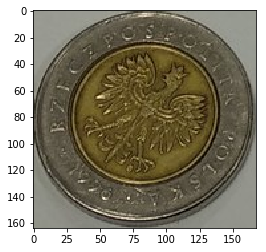

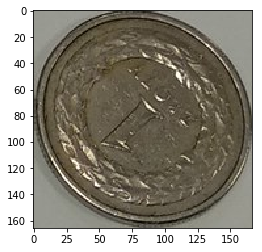

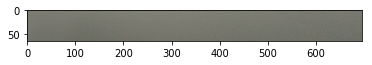

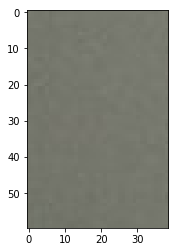

In [173]:
img = coin_imgs[0]
for region in measure.regionprops(label_img):
    print region.label, region.area
    bb = region.bbox
    if region.area > 20:
        plt.figure()
        coin = img[bb[0]:bb[2],bb[1]:bb[3]]
        plt.imshow(coin)
    
plt.show()

Powtórzmy teraz cały proces dla wszystkich obrazków 

In [214]:
def process_image(img):
    coins = []
    img_original = img.copy()
    img = color.rgb2gray(img)
    img = exposure.rescale_intensity(img)
    img_bin = img < 0.5
    
    img_bin = morphology.binary_closing(img_bin, selem=np.ones((20,20)))

    label_img = measure.label(img_bin)
    image_label_overlay = color.label2rgb(label_img, image=img)
    for region in measure.regionprops(label_img):                
        if region.area>100 and region.area<300*300:
            bb = region.bbox      
            coin = img_original[bb[0]:bb[2],bb[1]:bb[3]]
            coins.append(coin)
    return coins

coins = []
for img in coin_imgs:
    coins += process_image(img)
    

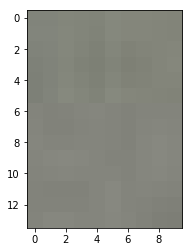

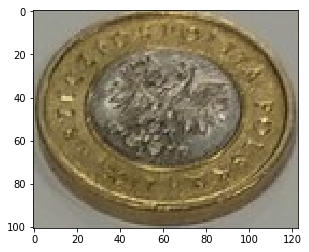

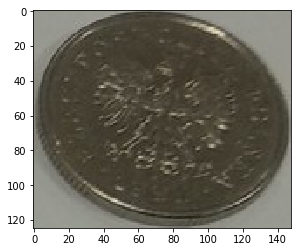

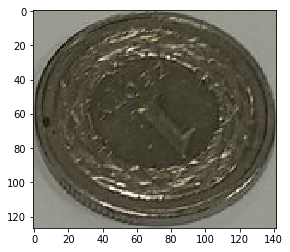

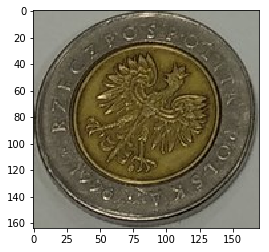

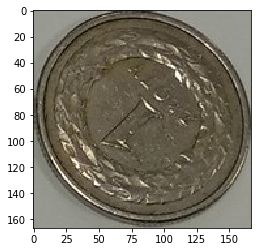

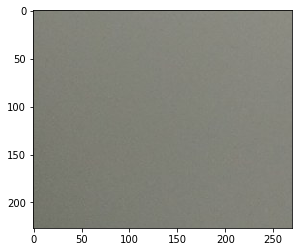

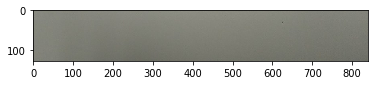

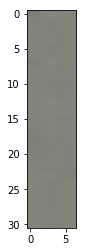

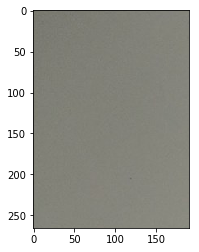

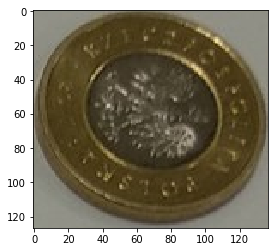

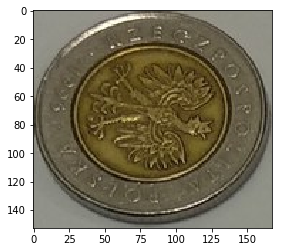

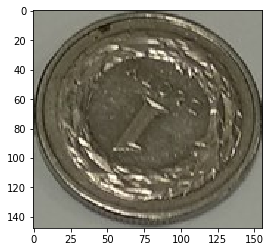

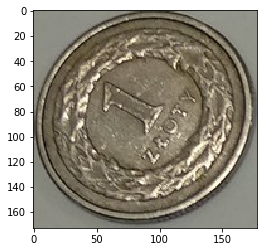

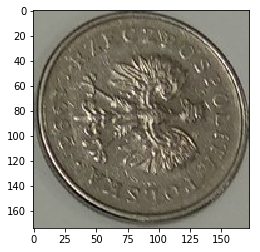

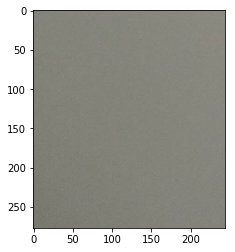

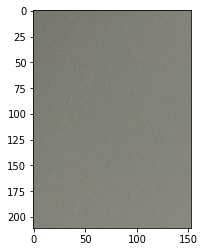

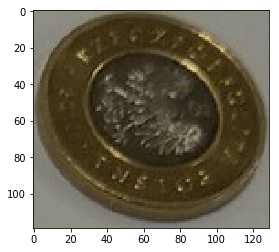

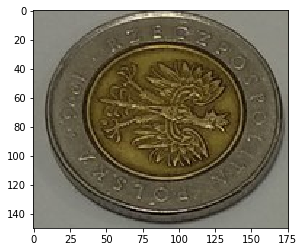

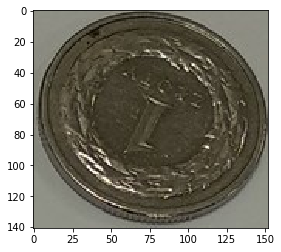

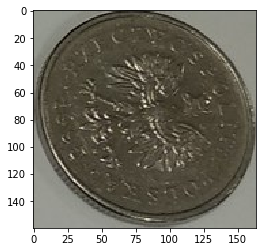

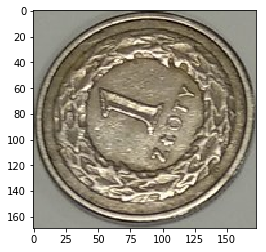

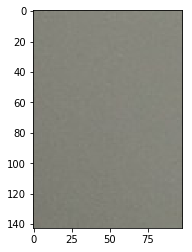

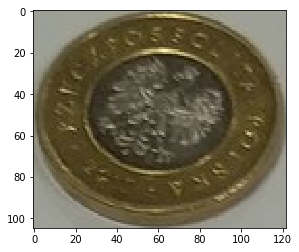

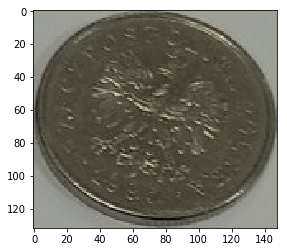

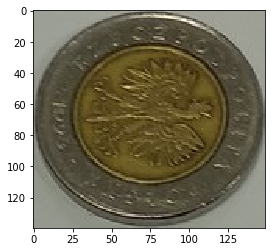

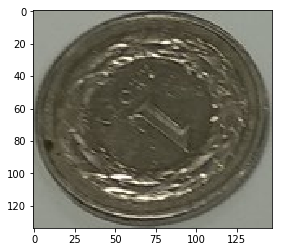

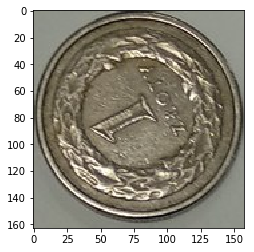

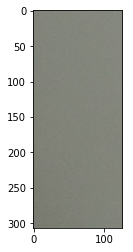

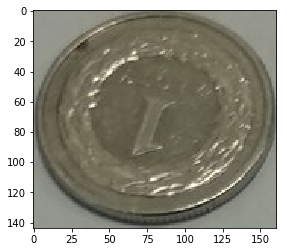

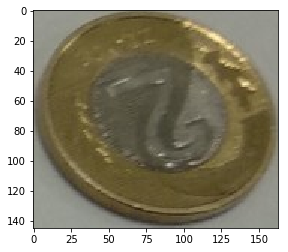

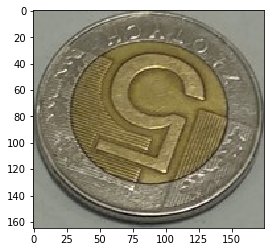

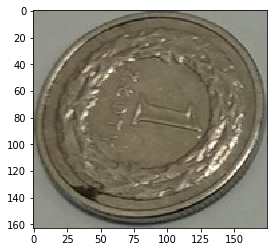

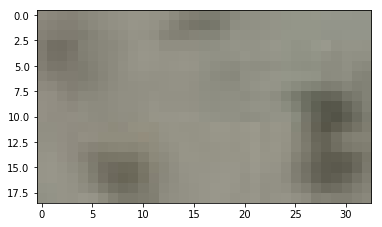

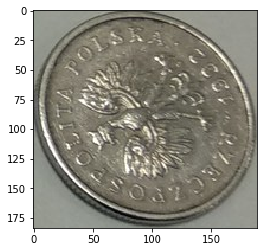

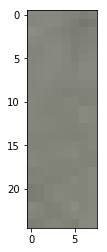

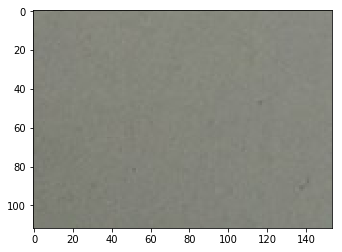

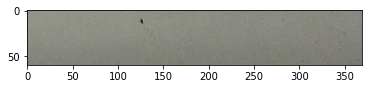

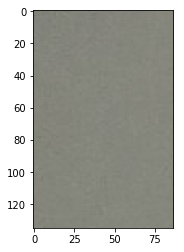

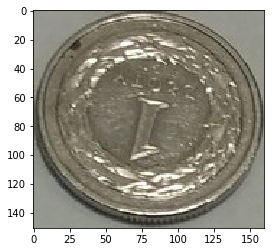

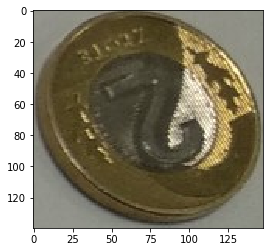

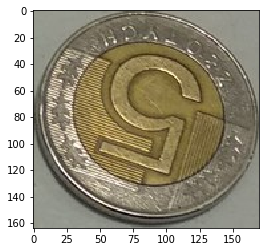

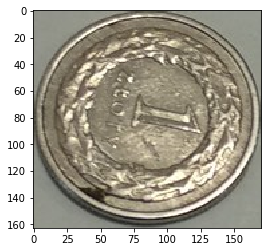

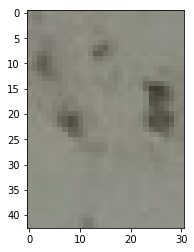

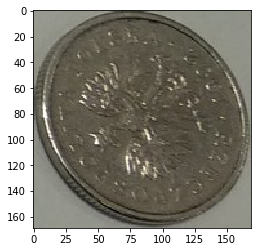

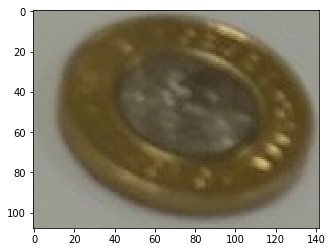

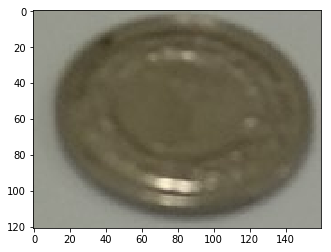

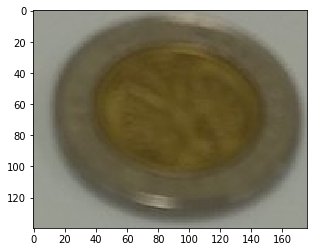

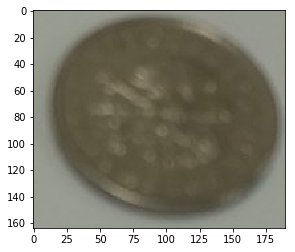

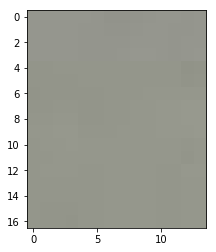

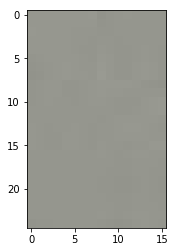

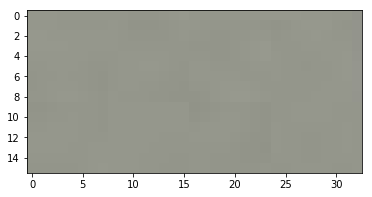

In [215]:
coin_areas = []
for coin in coins:
     plt.figure(); plt.imshow(coin)
    
plt.show()



In [222]:
labels = list('0211310000231110023111021311012310100001231012131000')
print len(labels), len(coins)

52 52


In [234]:

coin2feature = []
for coin, label in zip(coins, labels):
    coin = color.rgb2hsv(coin)
    coin_r = coin[:,:, 0]
    coin_b = coin[:,:, 1]
    coin_g = coin[:,:, 2]
#     plt.figure(); plt.imshow(coin); plt.title(label)

    
    coin2feature.append([coin_r.mean(),
                            coin_b.mean(),
                            coin_r.mean(), str(label)])
plt.show()

In [235]:
import pandas as pd
df = pd.DataFrame(coin2feature, columns = ['mh', 'ms', 'mv', 'target'])

df.to_csv('~/out.csv')

mh        float64
ms        float64
mv        float64
target     object
dtype: object
